Dataset Shape: (173, 36)

First 5 entries:


,Age,Weight_kg,Height_ft,Marital_Status,PCOS,Family_History_PCOS,Menstrual_Irregularity,Hormonal_Imbalance,Hyperandrogenism,Hirsutism,...,Diet_Multivitamin,Vegetarian,Exercise_Frequency,Exercise_Type,Exercise_Duration,Sleep_Hours,Stress_Level,Smoking,Exercise_Benefit,PCOS_Medication
0,20-25,66.0,157.48,Unmarried,No,No,Yes,No,No,No,...,0,No,Rarely,"Cardio (e.g., running, cycling, swimming)",30 minutes,Less than 6 hours,No,No,Somewhat,No.
1,Less than 20,56.0,165.10,Unmarried,No,No,No,No,No,No,...,0,No,Daily,No Exercise,Less than 30 minutes,6-8 hours,No,No,Somewhat,No.
2,Less than 20,89.0,167.64,Unmarried,No,Yes,No,No,No,Yes,...,0,No,Rarely,"Cardio (e.g., running, cycling, swimming)",Less than 30 minutes,6-8 hours,Yes,No,Somewhat,No.
3,20-25,55.0,160.02,Unmarried,No,Yes,No,Yes,No,Yes,...,1,No,Never,No Exercise,Not Applicable,6-8 hours,Yes,No,Somewhat,No.
4,Less than 20,55.0,160.02,Unmarried,No,No,No,No,No,No,...,0,No,Daily,"Cardio (e.g., running, cycling, swimming)",30 minutes to 1 hour,6-8 hours,Yes,No,Not at All,No.



Data types after preprocessing:
Age                              int8
Weight_kg                     float64
Marital_Status                  int64
PCOS                          float64
Family_History_PCOS           float64
Menstrual_Irregularity          int64
Hormonal_Imbalance            float64
Hyperandrogenism              float64
Hirsutism                     float64
Mental_Health                 float64
Conception_Difficulty         float64
Insulin_Resistance            float64
Diabetes                      float64
Childhood_Trauma              float64
Cardiovascular_Disease        float64
Diet_Bread_Cereals              int64
Diet_Milk_Products              int64
Diet_Fruits                     int64
Diet_Vegetables                 int64
Diet_Starchy_Vegetables         int64
Diet_NonStarchy_Vegetables      int64
Diet_Fats                       int64
Diet_Sweets                     int64
Diet_Fried_Food                 int64
Diet_Tea_Coffee                 int64
Diet_Multivitamin

C:\Users\Admin\AppData\Local\Temp\ipykernel_16044\3992106938.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[yes_no_cols] = df[yes_no_cols].replace({'Yes': 1, 'No': 0})


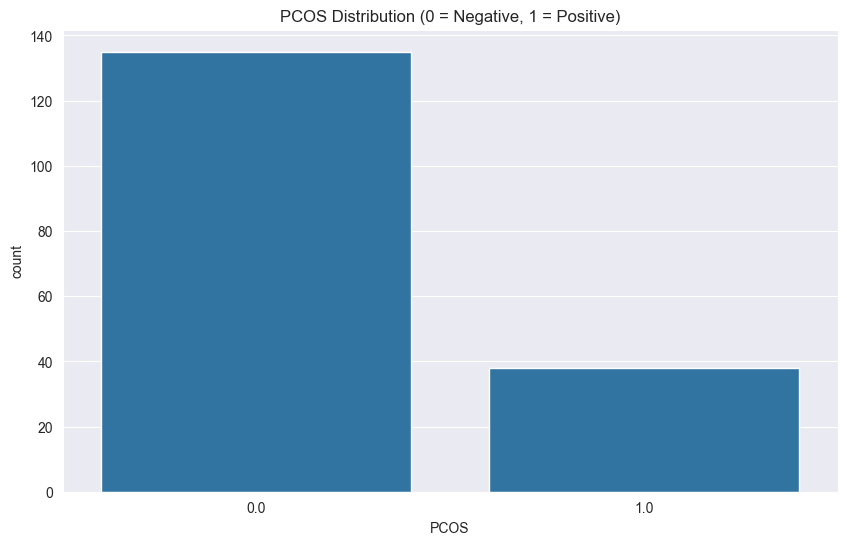

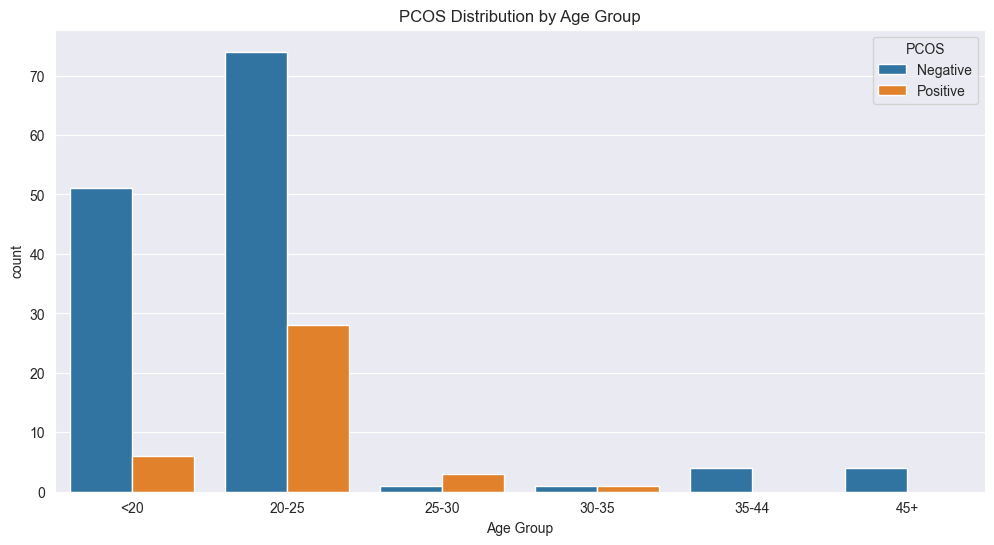

ValueError: Mask must have the same shape as data.

<Figure size 1600x1200 with 0 Axes>

In [4]:
# %% [markdown]
# # PCOS Prediction System with Explainable AI
# ## Comprehensive Analysis and Predictive Modeling

# %% [markdown]
# ## 1. Data Loading and Initial Exploration

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_curve, auc)
import gradio as gr
import shap

# Load data
df = pd.read_csv('input/Cleaned-Data.csv')

# Initial exploration
print("Dataset Shape:", df.shape)
print("\nFirst 5 entries:")
display(df.head())

# %% [markdown]
# ## 2. Data Preprocessing (Corrected)

# %%
# Convert height to meters
df['Height_m'] = df['Height_ft']/100
df.drop('Height_ft', axis=1, inplace=True)

# Age encoding
age_order = ['Less than 20', '20-25', '25-30', '30-35', '35-44', '45 and above']
df['Age'] = pd.Categorical(df['Age'], categories=age_order, ordered=True).codes

# Convert all Yes/No columns
yes_no_cols = ['PCOS', 'Family_History_PCOS', 'Menstrual_Irregularity',
               'Hormonal_Imbalance', 'Hirsutism', 'Diabetes', 'Cardiovascular_Disease',
               'Vegetarian', 'Smoking']
df[yes_no_cols] = df[yes_no_cols].replace({'Yes': 1, 'No': 0})

# Handle complex categorical columns
complex_categoricals = {
    'Exercise_Type': {
        'No Exercise': 0,
        'Cardio (e.g., running, cycling, swimming)': 1,
        'Strength training (e.g., weightlifting, resistance exercises)': 2,
        'Flexibility and balance (e.g., yoga, pilates)': 3,
        'High-intensity interval training (HIIT)': 4
    },
    'PCOS_Medication': {
        'No': 0,
        'Glucophage': 1,
        'Herbal': 2,
        'Multivitamins, Inositol': 3,
        'Yes, hormonal therapy (e.g., birth control pills)': 4
    }
}

for col, mapping in complex_categoricals.items():
    df[col] = df[col].map(mapping).fillna(0).astype(int)

# Convert remaining categoricals
df['Marital_Status'] = df['Marital_Status'].map({'Unmarried': 0, 'Married': 1, 'Widow': 2}).fillna(0)
df['Exercise_Frequency'] = df['Exercise_Frequency'].map({
    'Never': 0, 'Rarely': 1, '1-2 Times a Week': 2,
    '3-4 Times a Week': 3, 'Daily': 4
}).fillna(0)

# Convert all columns to numeric
df = df.apply(pd.to_numeric, errors='coerce').fillna(0)

# Create BMI feature
df['BMI'] = df['Weight_kg'] / (df['Height_m'] ** 2)

# %% [markdown]
# ## 3. Exploratory Data Analysis (Corrected)

# %%
# Verify numeric conversion
print("\nData types after preprocessing:")
print(df.dtypes)

# PCOS distribution
plt.figure(figsize=(10,6))
sns.countplot(x='PCOS', data=df)
plt.title('PCOS Distribution (0 = Negative, 1 = Positive)')
plt.show()

# Age distribution
plt.figure(figsize=(12,6))
age_labels = ['<20', '20-25', '25-30', '30-35', '35-44', '45+']
sns.countplot(x='Age', hue='PCOS', data=df)
plt.xticks(ticks=range(6), labels=age_labels)
plt.title('PCOS Distribution by Age Group')
plt.xlabel('Age Group')
plt.legend(title='PCOS', labels=['Negative', 'Positive'])
plt.show()

# Correlation matrix
plt.figure(figsize=(16,12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr[(corr['PCOS'].abs() > 0.3) | (corr['PCOS'].abs() < -0.3)], 
            annot=True, cmap='coolwarm', mask=mask)
plt.title('Feature Correlation with PCOS (|r| > 0.3)')
plt.show()

# %% [markdown]
# ## 4. Feature Engineering & Model Training

# %%
# Prepare data
X = df.drop('PCOS', axis=1)
y = df['PCOS']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest model
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Evaluate model
y_pred = best_rf.predict(X_test)
print(f"Best Model Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

# Feature importance
plt.figure(figsize=(12,8))
feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Top 15 Important Features for PCOS Prediction')
plt.xlabel('Relative Importance')
plt.show()

# %% [markdown]
# ## 5. SHAP Explainability

# %%
# SHAP analysis
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test[:50])

plt.figure(figsize=(12,8))
shap.summary_plot(shap_values[1], X_test[:50], feature_names=X.columns)
plt.title('SHAP Value Distribution for PCOS Prediction')
plt.show()

# %% [markdown]
# ## 6. Gradio Interface

# %%
def predict_pcos(age, weight, height, menstrual_irregular, exercise_freq):
    # Create input array
    input_data = pd.DataFrame({
        'Age': [age],
        'Weight_kg': [weight],
        'Height_m': [height/100],
        'Menstrual_Irregularity': [1 if menstrual_irregular else 0],
        'Exercise_Frequency': [exercise_freq]
    })
    
    # Add missing features with median values
    for col in X.columns:
        if col not in input_data.columns:
            input_data[col] = df[col].median()
    
    # Preprocess and predict
    scaled_input = scaler.transform(input_data)
    proba = best_rf.predict_proba(scaled_input)[0][1]
    
    # Generate explanation
    explanation = "Key contributing factors:\n"
    shap_values = explainer.shap_values(scaled_input)
    feature_importance = sorted(zip(X.columns, shap_values[1][0]), 
                               key=lambda x: abs(x[1]), reverse=True)[:3]
    
    for feature, value in feature_importance:
        explanation += f"- {feature}: {value:.2f}\n"
    
    # Generate recommendations
    recommendations = []
    if proba > 0.7:
        recommendations.append("Consult an endocrinologist")
    if weight > 70:
        recommendations.append("Consider weight management")
    if exercise_freq in ['Never', 'Rarely']:
        recommendations.append("Increase physical activity")
    
    return {
        "PCOS Risk Probability": float(proba),
        "Key Factors": explanation,
        "Recommendations": "\n".join(recommendations) if recommendations else "No specific recommendations"
    }

# Create interface
inputs = [
    gr.Dropdown(age_labels, label="Age Group"),
    gr.Slider(30, 150, step=0.5, label="Weight (kg)"),
    gr.Slider(140, 200, step=1, label="Height (cm)"),
    gr.Radio(["Yes", "No"], label="Menstrual Irregularity"),
    gr.Dropdown(["Daily", "3-4x/week", "1-2x/week", "Rarely", "Never"], 
               label="Exercise Frequency")
]

outputs = [
    gr.Label(label="Risk Assessment"),
    gr.Textbox(label="Key Factors"),
    gr.Textbox(label="Recommendations")
]

interface = gr.Interface(
    fn=predict_pcos,
    inputs=inputs,
    outputs=outputs,
    title="PCOS Risk Prediction System",
    description="Predict PCOS risk based on lifestyle and clinical factors",
    theme="default"
)

interface.launch(inline=True)